In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
loans_df = pd.read_csv('loans_dataset.csv')
loans_df.head(3)

,LoanID,Org Name,Org ID,OrgID & LoanID,Principal (€),Interest p.m.,Payout Date,Maturity Date,Status,Repaid Date,Outstanding Notional,Days Late,Months Repaid,Unnamed: 13,Unnamed: 14,RandInt
0,1.0,DriveTech GmbH,1026.0,1026-1,"13,778.00",1.25%,10-Nov-2019,4-Nov-2020,Repaid,14-Feb-2020,0,-264.0,3.20,NaN,"529,053.00",402782.0
1,2.0,Elixir GmbH,1027.0,1027-2,"43,051.00",1.40%,11-Nov-2019,5-Nov-2020,Repaid,03-Nov-2020,0,-2.0,11.93,NaN,NaN,305775.0
2,3.0,FlashForward GmbH,1028.0,1028-3,"13,896.00",1.25%,12-Nov-2019,6-Nov-2020,Repaid,03-Nov-2020,0,-3.0,11.90,NaN,NaN,239660.0


In [3]:
# I will drop some columns that are note needed to keep the dataset cleaned
loans_df = loans_df.drop(columns = ['LoanID','Unnamed: 13', 'Unnamed: 14','RandInt'])
loans_df.drop(loans_df.index[-1], inplace=True)

In [4]:
loans_df.dtypes

Org Name                 object
Org ID                  float64
OrgID & LoanID           object
Principal (€)            object
Interest p.m.            object
Payout Date              object
Maturity Date            object
Status                   object
Repaid Date              object
Outstanding Notional     object
Days Late               float64
Months Repaid           float64
dtype: object

In [5]:
# Some values are recongized as obejcts instead of floats, so I will conver them now
loans_df['Principal (€)'] = loans_df['Principal (€)'].str.replace(',', '').astype(float)
loans_df['Outstanding Notional'] = loans_df['Outstanding Notional'].str.replace(',', '').astype(float)

In [6]:
# Some exploratory analysis to check how the dataset is formed

number_of_loans = len(loans_df)
unique_customers = len(loans_df['Org ID'].unique())
min_principal = loans_df['Principal (€)'].min()
max_principal = loans_df['Principal (€)'].max()

print(f'The dataset contains {number_of_loans} loans. The loans have been financed across {unique_customers} unique lenders/customers.  \nThe lowest financing amount is {min_principal}€, while the highest is {max_principal}€.\nThe next step is to analyse the repayment behaviours of the customers and categprise them based on their risk profile.')


The dataset contains 300 loans. The loans have been financed across 174 unique lenders/customers.  
The lowest financing amount is 10311.0€, while the highest is 529053.0€.
The next step is to analyse the repayment behaviours of the customers and categprise them based on their risk profile.


In [7]:
# I created the following Risk Matrix to have a basis to categorise the level of riskiness of current customers based on their
# behaviour

![Image Description](risk_matrix.png)


In [8]:
# Checking the count of loans per organization

loan_counts_df = loans_df['Org ID'].value_counts().to_frame(name='number_of_loans')
loan_counts_df = loan_counts_df.reset_index().rename(columns={'index': 'Org ID'})
loan_counts_df

,Org ID,number_of_loans
0,1035.0,4
1,1067.0,4
2,1027.0,4
3,1076.0,4
4,1011.0,4
...,...,...
169,1053.0,1
170,1033.0,1
171,1032.0,1
172,1031.0,1


In [9]:
# Feature Engineering to add a column saying wether a loan payment is late or not

def encode_columns(row):
    if row['Days Late'] > 0:
        return 1
    else:
        return 0

loans_df['is_late'] = loans_df.apply(encode_columns, axis=1)
loans_df.head(3)


,Org Name,Org ID,OrgID & LoanID,Principal (€),Interest p.m.,Payout Date,Maturity Date,Status,Repaid Date,Outstanding Notional,Days Late,Months Repaid,is_late
0,DriveTech GmbH,1026.0,1026-1,13778.0,1.25%,10-Nov-2019,4-Nov-2020,Repaid,14-Feb-2020,0.0,-264.0,3.20,0
1,Elixir GmbH,1027.0,1027-2,43051.0,1.40%,11-Nov-2019,5-Nov-2020,Repaid,03-Nov-2020,0.0,-2.0,11.93,0
2,FlashForward GmbH,1028.0,1028-3,13896.0,1.25%,12-Nov-2019,6-Nov-2020,Repaid,03-Nov-2020,0.0,-3.0,11.90,0


In [10]:
# Checking the number of late loans per Org ID

late_loans_by_org = loans_df.groupby('Org ID')['is_late'].sum().reset_index(name='total_late_loans')

# Merging it with the original dataframe to get the number of total loans per Org ID

df_percentage_late_loans = loan_counts_df.merge(late_loans_by_org,on = "Org ID")

# Using the prvious information to get the % of late loans per Org ID

df_percentage_late_loans['percentage of late loans'] = df_percentage_late_loans['total_late_loans']/df_percentage_late_loans['number_of_loans']
df_percentage_late_loans.head()

,Org ID,number_of_loans,total_late_loans,percentage of late loans
0,1035.0,4,2,0.50
1,1067.0,4,2,0.50
2,1027.0,4,0,0.00
3,1076.0,4,0,0.00
4,1011.0,4,3,0.75


In [11]:
# In the original dataframe, 'Days Late' is calculated by substracting the maturity date from the repayment date, so loans that are not
# late will have a negative value
# At this stage, I want to know only about speicifc days late loans and so I will replace negtaive values with 0

loans_df['Days Late'] = np.where(loans_df['Days Late'] < 0, 0, loans_df['Days Late'])
loans_df.head()

,Org Name,Org ID,OrgID & LoanID,Principal (€),Interest p.m.,Payout Date,Maturity Date,Status,Repaid Date,Outstanding Notional,Days Late,Months Repaid,is_late
0,DriveTech GmbH,1026.0,1026-1,13778.0,1.25%,10-Nov-2019,4-Nov-2020,Repaid,14-Feb-2020,0.0,0.0,3.20,0
1,Elixir GmbH,1027.0,1027-2,43051.0,1.40%,11-Nov-2019,5-Nov-2020,Repaid,03-Nov-2020,0.0,0.0,11.93,0
2,FlashForward GmbH,1028.0,1028-3,13896.0,1.25%,12-Nov-2019,6-Nov-2020,Repaid,03-Nov-2020,0.0,0.0,11.90,0
3,GlobalLink GmbH,1029.0,1029-4,21926.0,1.25%,13-Nov-2019,7-Nov-2020,Repaid,01-Nov-2020,0.0,0.0,11.80,0
4,KryptonGmbH,1064.0,1064-5,24195.0,1.25%,10-Nov-2019,4-Nov-2020,Repaid,6-Nov-2020,0.0,2.0,12.07,1


In [12]:
# I want know to calculate the average days of late loans per Org ID so that I can create my risk matrix

average_late_days_df = loans_df[loans_df['Days Late'] > 0].groupby('Org ID')['Days Late'].mean().reset_index(name = 'average_late_days')
average_late_days_df.head(3)

,Org ID,average_late_days
0,1005.0,15.0
1,1006.0,2.0
2,1009.0,12.0


In [13]:
# Adding to my previous dataframe the information about average late days per Org by doing a merge

df_percentage_late_loans= df_percentage_late_loans.merge(average_late_days_df, how = 'left', on = 'Org ID')

# Filling the NaN with 0s, as not all customers have late loans

df_percentage_late_loans = df_percentage_late_loans.fillna({'average_late_days':0})
df_percentage_late_loans.head()

,Org ID,number_of_loans,total_late_loans,percentage of late loans,average_late_days
0,1035.0,4,2,0.50,3.5
1,1067.0,4,2,0.50,107480.0
2,1027.0,4,0,0.00,0.0
3,1076.0,4,0,0.00,0.0
4,1011.0,4,3,0.75,3.0


In [14]:
# Some customers have also not repaid loans so I want to add a column with that information too

customers_not_repaid_loans = loans_df[loans_df['Repaid Date'] == "Not Repaid Yet"].groupby('Org ID').size().reset_index(name='not_repaid_loans')
df_percentage_late_loans= df_percentage_late_loans.merge(customers_not_repaid_loans, how = 'left', on = 'Org ID')
df_percentage_late_loans = df_percentage_late_loans.fillna({'not_repaid_loans':0})
df_percentage_late_loans.head()


,Org ID,number_of_loans,total_late_loans,percentage of late loans,average_late_days,not_repaid_loans
0,1035.0,4,2,0.50,3.5,0.0
1,1067.0,4,2,0.50,107480.0,1.0
2,1027.0,4,0,0.00,0.0,0.0
3,1076.0,4,0,0.00,0.0,0.0
4,1011.0,4,3,0.75,3.0,0.0


In [15]:
# Creating a function that re-creates the idea of my risk matrix as shown above

def risk_categorization(average_late_days,percentage_late_loans):
    if average_late_days < 5 and percentage_late_loans < 0.1:
        return "Low Risk"
    elif average_late_days < 4 and percentage_late_loans > 0.11 and percentage_late_loans < 0.3:
        return "Low to Medium_Risk"
    elif average_late_days < 4 and percentage_late_loans > 0.31 or average_late_days >3 and average_late_days < 5 and percentage_late_loans > 0.10  and percentage_late_loans < 0.3 or average_late_days >5 and average_late_days < 15 and percentage_late_loans <0.3:
        return 'Medium Risk'
    elif average_late_days > 3 and average_late_days <= 15 and percentage_late_loans > 0.3 and percentage_late_loans < 0.5 or average_late_days >= 15 and percentage_late_loans < 0.3:
        return 'Medium to High'
    elif average_late_days > 3 and average_late_days < 15 and percentage_late_loans > 0.5 or average_late_days >= 15 and percentage_late_loans > 0.3 and percentage_late_loans < 0.5:
        return 'High Risk'
    else:
        return 'Very High Risk'

In [16]:
risk_categorization(16,0.09)

'Medium to High'

In [17]:
# Once I saw it is working, I update the dataframe with an extra column that states the riskiness of each organizations based on the
# conditions that I stated before

df_percentage_late_loans["risk_level"] = df_percentage_late_loans.apply(lambda row: risk_categorization(row["average_late_days"], row["percentage of late loans"]), axis=1)
df_percentage_late_loans

,Org ID,number_of_loans,total_late_loans,percentage of late loans,average_late_days,not_repaid_loans,risk_level
0,1035.0,4,2,0.50,3.5,0.0,Medium Risk
1,1067.0,4,2,0.50,107480.0,1.0,Very High Risk
2,1027.0,4,0,0.00,0.0,0.0,Low Risk
3,1076.0,4,0,0.00,0.0,0.0,Low Risk
4,1011.0,4,3,0.75,3.0,0.0,Medium Risk
...,...,...,...,...,...,...,...
169,1053.0,1,0,0.00,0.0,0.0,Low Risk
170,1033.0,1,0,0.00,0.0,0.0,Low Risk
171,1032.0,1,0,0.00,0.0,0.0,Low Risk
172,1031.0,1,0,0.00,0.0,1.0,Low Risk


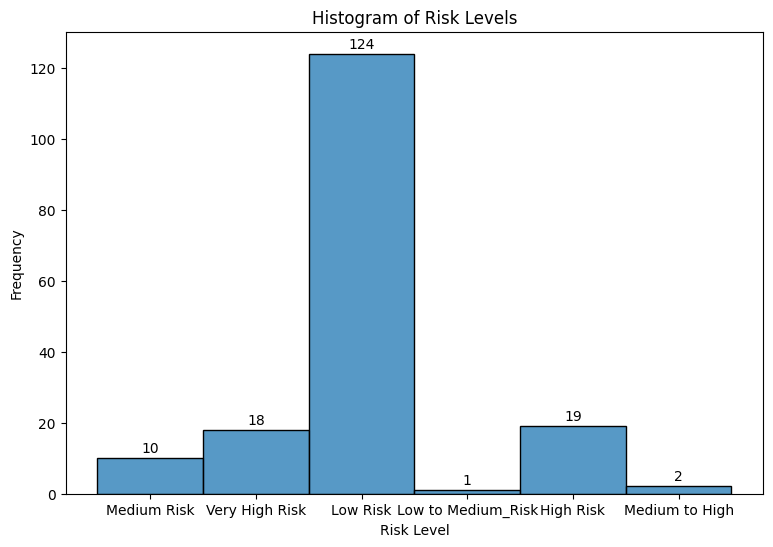

In [23]:
# Plotting now the spread of riskiness level

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the histogram with adjusted bar width
plt.figure(figsize=(9, 6))  # Adjust the width as needed
ax = sns.histplot(data=df_percentage_late_loans, x='risk_level', discrete=True)

# Add text labels for count on top of each bar
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 2),
                textcoords='offset points', ha='center', va='bottom')

plt.xlabel('Risk Level')
plt.ylabel('Frequency')
plt.title('Histogram of Risk Levels')

plt.show()


In [19]:
# Info about the portfolio risk
percentage_low_risk = round(len(df_percentage_late_loans[df_percentage_late_loans['risk_level'] == 'Low Risk']) / len(df_percentage_late_loans) *100,2)
print(f'{percentage_low_risk}% of the portoflio is composed by low risk customers')

71.26% of the portoflio is composed by low risk customers


In [24]:
loans_df.head(3)

,Org Name,Org ID,OrgID & LoanID,Principal (€),Interest p.m.,Payout Date,Maturity Date,Status,Repaid Date,Outstanding Notional,Days Late,Months Repaid,is_late,repayment_status
0,DriveTech GmbH,1026.0,1026-1,13778.0,1.25%,10-Nov-2019,4-Nov-2020,Repaid,14-Feb-2020,0.0,0.0,3.20,0,2
1,Elixir GmbH,1027.0,1027-2,43051.0,1.40%,11-Nov-2019,5-Nov-2020,Repaid,03-Nov-2020,0.0,0.0,11.93,0,4
2,FlashForward GmbH,1028.0,1028-3,13896.0,1.25%,12-Nov-2019,6-Nov-2020,Repaid,03-Nov-2020,0.0,0.0,11.90,0,4


In [25]:
# As next step now I want to check whether for each roganization there is a pattern on repayment time and possibly use that
# for repayment monitoring

In [26]:
def function(row):
    # Converting 'Payout Date' to a datetime object if it is not already
    payout_date = pd.to_datetime(row['Payout Date'], errors='coerce')
    if pd.isnull(payout_date):
        return None

    if row['Repaid Date'] == 'Not Repaid Yet':
        return 'Not Repaid Yet'

    try:
        repaid_date = pd.to_datetime(row['Repaid Date'])
    except ValueError:
        return None

    if repaid_date <= (payout_date + pd.Timedelta(days=90)):
        return 1
    elif repaid_date <= (payout_date + pd.Timedelta(days=180)):
        return 2
    elif repaid_date <= (payout_date + pd.Timedelta(days=270)):
        return 3
    elif repaid_date <= (payout_date + pd.Timedelta(days=360)):
        return 4
    else:
        return 5


# Applying the function to each row of the DataFrame
loans_df['repayment_status'] = loans_df.apply(function, axis=1)
loans_df.head(3)


,Org Name,Org ID,OrgID & LoanID,Principal (€),Interest p.m.,Payout Date,Maturity Date,Status,Repaid Date,Outstanding Notional,Days Late,Months Repaid,is_late,repayment_status
0,DriveTech GmbH,1026.0,1026-1,13778.0,1.25%,10-Nov-2019,4-Nov-2020,Repaid,14-Feb-2020,0.0,0.0,3.20,0,2
1,Elixir GmbH,1027.0,1027-2,43051.0,1.40%,11-Nov-2019,5-Nov-2020,Repaid,03-Nov-2020,0.0,0.0,11.93,0,4
2,FlashForward GmbH,1028.0,1028-3,13896.0,1.25%,12-Nov-2019,6-Nov-2020,Repaid,03-Nov-2020,0.0,0.0,11.90,0,4


In [27]:
# Checking average repayment time of each Org ID
result = loans_df[loans_df['repayment_status'] != 'Not Repaid Yet'].groupby('Org ID')['repayment_status'].mean().reset_index(name='avg_repayment_time')
result

,Org ID,avg_repayment_time
0,1001.0,2.000000
1,1002.0,4.000000
2,1003.0,2.500000
3,1004.0,4.000000
4,1005.0,4.666667
...,...,...
157,1169.0,1.000000
158,1170.0,4.000000
159,1171.0,1.000000
160,1173.0,4.000000


In [29]:
# Constantly working and updating this project